<a href="https://colab.research.google.com/github/Alafiade/Implementing-PTQ-using-Eager-Mode/blob/main/PTQ_USING_EAGER_MODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTNG DEPENDENCIES


In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

DATA PREPROCESSING

In [2]:
transform = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.2023,0.1994,0.2010))
])





batch_size = 128

train_data = torchvision.datasets.CIFAR10(root='./data', train =True, download=True,transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download = True, transform=transform)

train_loader =  torch.utils.data.DataLoader(train_data ,batch_size= batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size,shuffle=False, num_workers=2, pin_memory = True)

train_size = len(train_data)
test_size = len(test_data)

classes = ('plane','car','bird','cat','deer','dog','frog', 'horse','ship','truck')
device = torch.device('cuda' if torch.cuda.is_available()else 'cpu')

100%|██████████| 170M/170M [00:03<00:00, 43.0MB/s]


VISUALIZING THE TRANSFORMED IMAGES

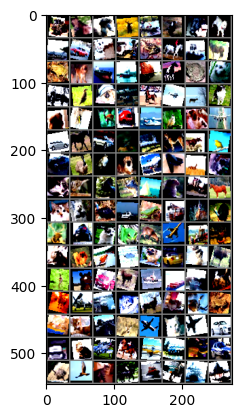

truckhorsebird deer ship bird dog  dog  planecar  dog  truckfrog horseship horsefrog dog  ship ship truckhorsefrog cat  horsebird dog  horsehorseplanedeer dog  dog  bird deer truckship bird dog  planecar  horsecar  deer planedog  deer bird car  bird frog dog  planeplanedeer cat  cat  bird bird bird ship bird truckhorsecat  dog  bird car  frog truckdeer bird deer car  dog  frog deer planeplanedeer deer dog  ship bird dog  car  dog  deer deer horsecar  deer ship ship ship cat  horseplaneship ship deer cat  deer frog cat  cat  truckdeer planecat  planecar  truckcat  planehorseplaneship cat  car  bird bird cat  horseship truckship plane


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img/ 2 +0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(''.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

IMPORTING RESNET ARCHITECTURE

In [4]:
import torchvision.models as models
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs =  model.fc.in_features
model.fc = nn.Linear(num_ftrs,10) #Modifying Last layer
model.train()
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

DEFINING THE SDG OPTIMIZER

In [5]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay =5e-4)

IMPLEMENTING EARLY STOPPING

In [6]:
class EarlyStopping:
  def __init__(self,patience=5):
    self.patience= patience
    self.best_acc = 0.0
    self.counter = 0
    self.stop_training = False

  def check_early_stop(self,val_acc):
    if val_acc > self.best_acc:
      self.best_acc = val_acc
      self.counter  = 0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        print(f'Early stopping triggered after {self.patience} epochs')
        self.stop_training = True

DEFINING THE TRAINING LOOP

In [7]:
def train_model_with_early_stopping(model, criterion, optimizer, num_epochs=30, patience=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Initialize the early stopping object
    early_stopping = EarlyStopping(patience=patience)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / test_size
        val_acc = val_corrects.double() / test_size

        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Save best model weights
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

        # Check early stopping
        early_stopping.check_early_stop(val_acc)
        if early_stopping.stop_training:
            print(f"Training stopped at epoch {epoch+1}")
            break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f'Best Validation Accuracy: {best_acc:.4f}')
    return model

model = train_model_with_early_stopping(model,criterion,optimizer,num_epochs=30)

Epoch 1/30
----------
Train Loss: 1.4378 Acc: 0.4858
Val Loss: 1.1376 Acc: 0.5960
Epoch 2/30
----------
Train Loss: 1.0497 Acc: 0.6299
Val Loss: 0.9768 Acc: 0.6495
Epoch 3/30
----------
Train Loss: 0.9256 Acc: 0.6743
Val Loss: 0.8785 Acc: 0.6927
Epoch 4/30
----------
Train Loss: 0.8476 Acc: 0.7025
Val Loss: 0.8423 Acc: 0.7077
Epoch 5/30
----------
Train Loss: 0.7944 Acc: 0.7216
Val Loss: 0.8075 Acc: 0.7188
Epoch 6/30
----------
Train Loss: 0.7528 Acc: 0.7367
Val Loss: 0.7767 Acc: 0.7323
Epoch 7/30
----------
Train Loss: 0.7123 Acc: 0.7508
Val Loss: 0.7350 Acc: 0.7437
Epoch 8/30
----------
Train Loss: 0.6822 Acc: 0.7614
Val Loss: 0.7281 Acc: 0.7479
Epoch 9/30
----------
Train Loss: 0.6617 Acc: 0.7687
Val Loss: 0.7146 Acc: 0.7555
Epoch 10/30
----------
Train Loss: 0.6379 Acc: 0.7739
Val Loss: 0.6890 Acc: 0.7611
Epoch 11/30
----------
Train Loss: 0.6122 Acc: 0.7845
Val Loss: 0.6942 Acc: 0.7588
Epoch 12/30
----------
Train Loss: 0.5953 Acc: 0.7887
Val Loss: 0.6768 Acc: 0.7678
Epoch 13/30
-

SAVING FP32 MODEL

In [8]:
torch.save(model.state_dict(),'model_weights.pth')

In [9]:
device = torch.device('cpu')

IMPLEMENTING THE POST TRAINING QUANTZATION WORKFLOW USING EAGER MODE

In [42]:
import copy
backend = 'fbgemm'
model.to('cpu')#Moving FP32 model to CPU
m = copy.deepcopy(model)


m.eval() #Setting model to evaluation

#Fusing the  models layer
from torch.quantization import fuse_modules
model_to_fuse = m
model_to_fuse = fuse_modules(model_to_fuse,['conv1','bn1','relu'], inplace=True)
for layer_name in ['layer1','layer2','layer3','layer4']:
  layer = getattr(model_to_fuse, layer_name)
  for block_idx in range(len(layer)):
    block = layer[block_idx]

    block = fuse_modules(block,['conv1','bn1','relu'], inplace=True)
    block = fuse_modules(block, ['conv2','bn2'], inplace = True)

    if block.downsample is not None:
      block.downsample = fuse_modules(block.downsample,['0','1'], inplace=True)
# Inserting Stubs
m = nn.Sequential(torch.quantization.QuantStub(),m,
                  torch.quantization.DeQuantStub())

# Preparing the model for Quantization

m.qconfig = torch.quantization.get_default_qconfig(backend)
torch.quantization.prepare(m,inplace=True)

# Calibration

calibration_transform = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.203,0.1994,0.2010))
])

batch_size = 128
calibration_dataset = torchvision.datasets.CIFAR10(
    root= './data',
    train=True,
    download=True,
    transform=calibration_transform

)

calibration_loader = torch.utils.data.DataLoader(
    calibration_dataset,
    batch_size= batch_size,
    shuffle=True,
    num_workers = 2,
    pin_memory = True
)

def calibrate(m,calibration_loader):
  m.eval()
  with torch.no_grad():
    for inputs, labels in calibration_loader:
      m.to(device)
      inputs, labels = inputs.to(device), labels.to(device)
      m(inputs)


calibrate(m, calibration_loader)

# Convert

torch.quantization.convert(m, inplace=True)




Sequential(
  (0): Quantize(scale=tensor([0.0407]), zero_point=tensor([59]), dtype=torch.quint8)
  (1): ResNet(
    (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.022527232766151428, zero_point=0, padding=(3, 3))
    (bn1): Identity()
    (relu): Identity()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.01417973916977644, zero_point=0, padding=(1, 1))
        (bn1): Identity()
        (relu): Identity()
        (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.034271713346242905, zero_point=70, padding=(1, 1))
        (bn2): Identity()
      )
      (1): BasicBlock(
        (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.01706084795296192, zero_point=0, padding=(1, 1))
        (bn1): Identity()
        (relu): Identity()

COMPARING MODEL SIZE

In [24]:
import os
import torch

def get_model_size(model, filename='temp.p'):
  torch.save(model.state_dict(), filename)
  size = os.path.getsize(filename)
  os.remove(filename)  # Remove temporary file
  return size / 1e6

original_model_size = get_model_size(model, 'original_model_temp.p')
quantized_size = get_model_size(m, 'quantized_model_temp.p')

print(f'Original Model size: {original_model_size:.2f} MB')
print(f'Quantized Model size: {quantized_size:.2f} MB')
print(f'Size reduction: {(1-quantized_size/original_model_size)*100:.2f}%')

Original Model size: 44.81 MB
Quantized Model size: 11.31 MB
Size reduction: 74.76%


In [16]:
print(f"Test loader has {len(test_loader)} batches")
for images, labels in test_loader:
    print(f"Sample batch has {len(images)} images")
    break

Test loader has 79 batches
Sample batch has 128 images


In [38]:
print (m)

Sequential(
  (0): Quantize(scale=tensor([0.0203]), zero_point=tensor([119]), dtype=torch.quint8)
  (1): ResNet(
    (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.011225184425711632, zero_point=0, padding=(3, 3))
    (bn1): Identity()
    (relu): Identity()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.007005244959145784, zero_point=0, padding=(1, 1))
        (bn1): Identity()
        (relu): Identity()
        (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.017018435522913933, zero_point=141, padding=(1, 1))
        (bn2): Identity()
      )
      (1): BasicBlock(
        (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.008490929380059242, zero_point=0, padding=(1, 1))
        (bn1): Identity()
        (relu): Identi

EVALUATING THE ACCURACY OF THE QUANT MODEL ON 1000 SAMPLES OF TEST DATA

In [74]:
import torch
from tqdm import tqdm

def quick_check(m, test_loader, num_samples=1000, device='cpu'):
    m.eval()  # Set the model to evaluation mode
    results = []
    samples_checked = 0  # Keep track of the number of processed samples

    with torch.no_grad():  # Disable gradients to speed up inference
        for data, target in tqdm(test_loader, desc="Evaluating"):
            data, target = data.to(device), target.to(device)  # Move data to device (CPU/GPU)
            batch_size = data.shape[0]  # Get the batch size (128 in your case)

            # Determine how many samples to take from this batch
            limit = min(num_samples - samples_checked, batch_size)

            # Run model on the required number of samples
            output = m(data[:limit])
            preds = output.argmax(dim=1)  # Get class predictions

            # Store results
            for i in range(limit):
                pred = preds[i].item()
                actual = target[i].item()
                correct = (pred == actual)
                results.append((pred, actual, correct))

            samples_checked += limit  # Update the number of checked samples

            # Stop when we reach 1000 samples
            if samples_checked >= num_samples:
                break

    if len(results) == 0:
        print("No valid samples processed.")
        return 0.0

    accuracy = 100.0 * sum(r[2] for r in results) / len(results)
    print(f"Accuracy on {len(results)} samples: {accuracy:.2f}%")
    return accuracy

# Example usage
acc = quick_check(model, test_loader, num_samples=1000, device='cpu')
print(f"Final Accuracy: {acc:.2f}%")


Evaluating:   9%|▉         | 7/79 [00:01<00:16,  4.37it/s]

Accuracy on 1000 samples: 80.90%
Final Accuracy: 80.90%
